In [1]:
import cbpro
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# public client
pub_client = cbpro.PublicClient()

# authenticated client
API_KEY = '6a98ae56410c2af32a9a75f1e719c7ee'
API_SECRET = 'QDCwPONUx7otS3LrTXh14iD/m54kq/Km5ZdcgAKjTRUxYRM/sT92doCQRL2/RMx0P/JNL71WfLvouEOm8p2AmQ=='
API_PASS = 'br63f1viwn'

auth_client = cbpro.AuthenticatedClient(API_KEY, API_SECRET, API_PASS)

pd.set_option('display.max_rows',None)

# Make a test bed for strategies

In [2]:
# get 15min, 1hr data
price_15min = pd.DataFrame(pub_client.get_product_historic_rates('BTC-USD', granularity=900),
                           columns=['time','low','high','open','close','volume']).sort_values('time')
price_15min['time'] = pd.to_datetime(price_15min['time'],unit='s')
price_15min.set_index('time', inplace=True)

price_60min = pd.DataFrame(pub_client.get_product_historic_rates('BTC-USD', granularity=3600),
                           columns=['time','low','high','open','close','volume']).sort_values('time')
price_60min['time'] = pd.to_datetime(price_60min['time'],unit='s')
price_60min.set_index('time', inplace=True)

In [3]:
# # get historical data
# price_15min_hist = pd.read_csv('~/Downloads/XBT_OHLCVT/XBTUSD_15.csv', header=None)
# price_15min_hist.columns = ['time','open','high','low','close','volume','trades']
# price_15min_hist['time'] = pd.to_datetime(price_15min_hist['time'],unit='s')
# price_15min_hist.set_index('time', inplace=True)
# price_15min_hist = price_15min_hist.query("time > '2021-06-15'")

# price_60min_hist = pd.read_csv('~/Downloads/XBT_OHLCVT/XBTUSD_60.csv', header=None)
# price_60min_hist.columns = ['time','open','high','low','close','volume','trades']
# price_60min_hist['time'] = pd.to_datetime(price_60min_hist['time'],unit='s')
# price_60min_hist.set_index('time', inplace=True)
# price_60min_hist = price_60min_hist.query("time > '2021-06-15'")

In [4]:
# helper functions for technical indicators
def _get_rsi(price, window=14):
    delta = price['close'].diff()
    up_days = delta.copy()
    up_days[delta<=0]=0.0
    down_days = abs(delta.copy())
    down_days[delta>0]=0.0
    RS_up = up_days.rolling(window).mean()
    RS_down = down_days.rolling(window).mean()
    rsi= 100-100/(1+RS_up/RS_down)
    return rsi


def _get_macd(price, window_1=12, window_2=26, os_window=9):
    ewm_12 = price['close'].ewm(span=window_1, adjust=False).mean()
    ewm_26 = price['close'].ewm(span=window_2, adjust=False).mean()
    macd = ewm_12 - ewm_26
    macd_ema = macd.ewm(span=os_window, adjust=False).mean()
    os = (macd - macd_ema)
    return macd, macd_ema, os

In [5]:
# dummy get_signal function
def get_signal(time, ind_15min, ind_60min):
    
    # get indicators
    rsi_15min, macd_15min, macd_ema_15min, os_15min, vol_15min = ind_15min
    rsi_60min, macd_60min, macd_ema_60min, os_60min, vol_60min = ind_60min
    
    # get index
    time_15min = time
    time_15min_1 = time_15min - timedelta(minutes=15)
    time_15min = time_15min.strftime('%Y-%m-%d %H:%M:00')
    time_15min_1 = time_15min_1.strftime('%Y-%m-%d %H:%M:00')

    time_60min = time
    time_60min_1 = time_60min - timedelta(minutes=60)
    time_60min = time_60min.strftime('%Y-%m-%d %H:00:00')
    time_60min_1 = time_60min_1.strftime('%Y-%m-%d %H:00:00')
    
    # dummy strategy
    if rsi_60min.loc[time_60min] < 40 and (os_60min.loc[time_60min_1] < 0 and os_60min.loc[time_60min] > 0):
        return 1.0
    elif rsi_60min.loc[time_60min] > 70 and (os_60min.loc[time_60min_1] > 0 and os_60min.loc[time_60min] < 0):
        return -1.0
    else:
        return 0

In [6]:
# simulate
def simulate_strategy(price_15min, price_60min, slippage = 0.005, seed = 1000, sl_pct = 0.07):

    def hold(i):
        port_df.iloc[i+1,0] = port_df.iloc[i,0]
        port_df.iloc[i+1,1] = port_df.iloc[i,1]
        port_df.iloc[i+1,3] = port_df.iloc[i,3]
    
    # get indicators
    rsi_15min = _get_rsi(price_15min)
    macd_15min, macd_ema_15min, os_15min = _get_macd(price_15min)
    vol_15min = price_15min['volume']
    ind_15min = rsi_15min, macd_15min, macd_ema_15min, os_15min, vol_15min

    rsi_60min = _get_rsi(price_60min)
    macd_60min, macd_ema_60min, os_60min = _get_macd(price_60min)
    vol_60min = price_60min['volume']
    ind_60min = rsi_60min, macd_60min, macd_ema_60min, os_60min, vol_60min
    
    # start with seed money (in USD)
    port_df = pd.DataFrame(rsi_60min)
    port_df[:] = 0
    port_df['btc'] = 0.
    port_df['total'] = 0.
    port_df['buy_price'] = 0.
    port_df['current_price'] = 0.
    port_df['action'] = 0.
    port_df['stoploss'] = 0.
    port_df.columns = ['usd','btc','current_price','buy_price','action','stoploss','total']
    port_df.iloc[0,0] = seed
    port_df.iloc[0,-1] = seed
    
    # simulate
    for i, time in enumerate(price_60min.index):
        
        # stop loss - if we hold btc and current price is X% lower than transaction place, stop loss
        if port_df.iloc[i,1] > 0. and price_60min.iloc[i,3] < port_df.iloc[i,3] * (1-sl_pct):
            btc_amount = port_df.iloc[i,1]
            usd_amount = btc_amount * price_60min.iloc[i,3] * (1-sl_pct) * (1-slippage)
            port_df.iloc[i,0] = port_df.iloc[i,0] + usd_amount
            port_df.iloc[i,1] = 0
            port_df.iloc[i,5] = True
            
        # get result of past trade
        port_df.iloc[i,2] = price_60min.loc[time]['close']
        port_df.iloc[i,-1] = port_df.iloc[i,0] + port_df.iloc[i,1] * port_df.iloc[i,2]

        # if last index, pass
        if i == len(price_60min)-1:
            return port_df
        
        # if rsi 15min is nan, pass
        if np.isnan(rsi_60min.loc[time]):
            hold(i)
            continue
        
        # get signal
        signal = get_signal(time, ind_15min, ind_60min)
        
        # buy from 1 hr signal
        if signal > 0:
#             print('buy')
            usd_amount = port_df.iloc[i,0] * signal
            btc_amount = usd_amount * (1-slippage) / price_60min.loc[time]['close']
            port_df.iloc[i+1,0] = port_df.iloc[i,0] - usd_amount
            port_df.iloc[i+1,1] = port_df.iloc[i,1] + btc_amount
            port_df.iloc[i+1,3] = price_60min.loc[time]['close']
            port_df.iloc[i,4] = 'buy'
#                 print(port_df.iloc[i+1,:])
                
        # sell from 15min signal - only if we hold btc
        elif signal < 0:
#             print('sell')
            if port_df.iloc[i,1] > 0.:
                btc_amount = port_df.iloc[i,1] * np.abs(signal)
                usd_amount = btc_amount * price_60min.loc[time]['close'] * (1-slippage)
                port_df.iloc[i+1,0] = port_df.iloc[i,0] + usd_amount
                port_df.iloc[i+1,1] = port_df.iloc[i,1] - btc_amount
                port_df.iloc[i+1,3] = price_60min.loc[time]['close']
                port_df.iloc[i,4] = 'sell'
#                 print(port_df.iloc[i+1,:])
            else:
                hold(i)
        else:
            hold(i)

    return port_df

In [7]:
# port_df = simulate_strategy(price_15min_hist, price_60min_hist, slippage = 0.005, seed = 1000, sl_pct = 0.03)
port_df = simulate_strategy(price_15min, price_60min, slippage = 0.005, seed = 1000, sl_pct = 0.05)
port_df.tail(20)

,usd,btc,current_price,buy_price,action,stoploss,total
time,,,,,,,
2021-08-21 23:00:00,1059.974407,0.0,48867.02,47560.75,0.0,0.0,1059.974407
2021-08-22 00:00:00,1059.974407,0.0,49000.01,47560.75,0.0,0.0,1059.974407
2021-08-22 01:00:00,1059.974407,0.0,49069.46,47560.75,0.0,0.0,1059.974407
2021-08-22 02:00:00,1059.974407,0.0,48874.19,47560.75,0.0,0.0,1059.974407
2021-08-22 03:00:00,1059.974407,0.0,48829.17,47560.75,0.0,0.0,1059.974407
2021-08-22 04:00:00,1059.974407,0.0,49150.01,47560.75,0.0,0.0,1059.974407
2021-08-22 05:00:00,1059.974407,0.0,49169.03,47560.75,0.0,0.0,1059.974407
2021-08-22 06:00:00,1059.974407,0.0,49207.99,47560.75,0.0,0.0,1059.974407
2021-08-22 07:00:00,1059.974407,0.0,49234.03,47560.75,0.0,0.0,1059.974407


<AxesSubplot:xlabel='time'>

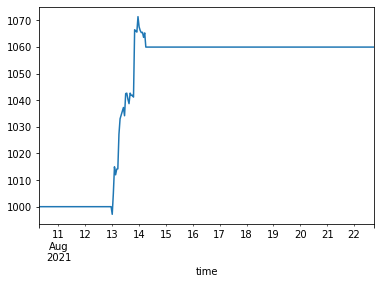

In [8]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
port_df.total.plot.line(ax=ax)